## İmport Libraries

In [134]:
import os 
import time
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import callbacks
from termcolor import colored
from IPython.display import display
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

%matplotlib inline


 ## Dataset Overview

In [135]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _,filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':
            if dir_name.split()[-1]!='GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name,filename))

dataset = pd.DataFrame(columns=['path','label'])
dataset['path'] = path
dataset['label'] = label

In [136]:
dataset

path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream

[9000 rows x 2 columns]

In [137]:
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

**We have a total of 9000 samples in the dataset. And we have 9 labels.**

**There are 1000 samples of each label value**

In [138]:
dataset['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

In [139]:
# Shuffle the DataFrame and reset index
dataset = dataset.sample(frac=1).reset_index(drop = True)

# Show the result
dataset.head(5)


path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Black Sea Sprat
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Mullet
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Mullet

In [140]:
dataset

path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Black Sea Sprat
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Mullet
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Mullet
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Gilt-Head Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Mullet
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Gilt-Head Bream

[9000 rows x 2 columns]

## Data Visualization

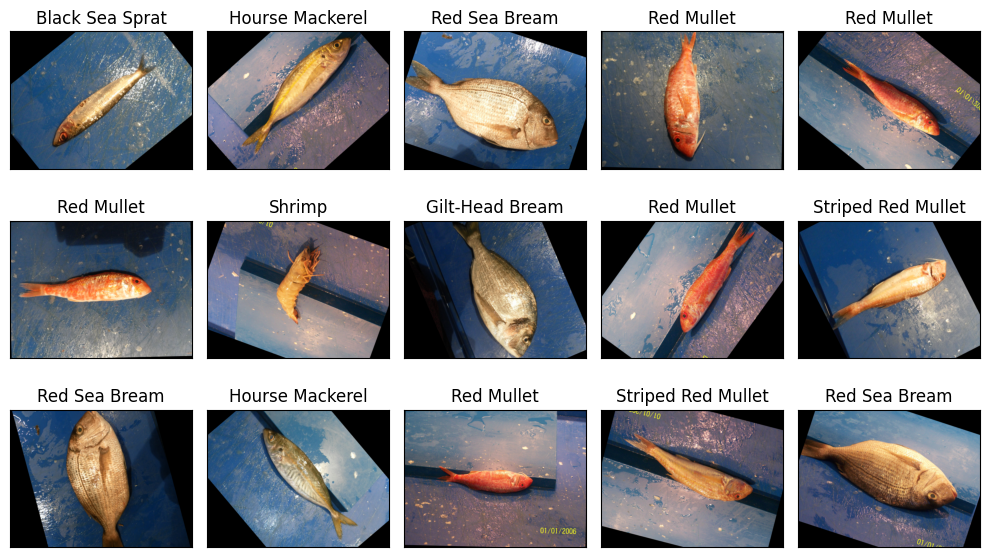

In [141]:
#Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataset.path[i]))
    ax.set_title(dataset.label[i])
plt.tight_layout()
plt.show()

**Reading images and adjusting image dimensions**

In [142]:
main_directory = fish_dir
images, labels = [], []

for directory in tqdm(os.listdir(main_directory)):
    next_directory = os.path.join(main_directory, directory)
    if directory in ["README.txt", "license.txt", "Segmentation_example_script.m"]:
        continue
    for images_directory in os.listdir(next_directory):
        if "GT" not in images_directory:
            final_directory = os.path.join(next_directory, images_directory)
            for image in os.listdir(final_directory):
                img_path = os.path.join(final_directory, image)
                with Image.open(img_path) as img:
                    img = img.resize((225, 225))  # Boyutlandırma
                    img_array = np.asarray(img).astype('float32') / 255  # Normalize etme
                    images.append(img_array)
                    labels.append(images_directory)

100%|██████████| 12/12 [02:43<00:00, 13.62s/it]



**In total, 80% of 9000 images for training set, 20% for cross validation and test set.**


**Training set 7200 samples, Cross validation 900 samples, Test set 900 samples.**


In [143]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


**Increasing image clarity**

In [144]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
datagen.fit(X_train)

**Converting data to numpy array for model (for numerical processing)**

In [145]:
X_train = np.array([x for x in X_train])
y_train = np.array([y for y in y_train])
X_val = np.array([x for x in X_val])
y_val = np.array([y for y in y_val])
X_test = np.array([x for x in X_test])
y_test = np.array([y for y in y_test])

**One-Hot Encoding**



**Representation of categorical variables as binary (0-1)**

**Rewriting in a format that machines can understand in the type of numerical processing**


In [146]:
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


 ## Creating the ANN Model architecture


**We created a 5-layer neural network**

**There are 2 drop layers for regularization**

**Input dimension is 3D vector. That is RGB**



In [147]:

# Set the input shape of the model
input_shape = (225,225,3)

# Build the custom ANN model
model=keras.Sequential([
    layers.Flatten(input_shape=input_shape), # Flatten the 3D image to 1D vector
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2), #Regularization
    layers.Dense(128, activation='relu'),
    layers.Dropout(0,2),
    layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 151875)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    38,880,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,914,313 (148.45 MB)

 Trainable params: 38,914,313 (148.45 MB)

 Non-trainable params: 0 (0.00 B)

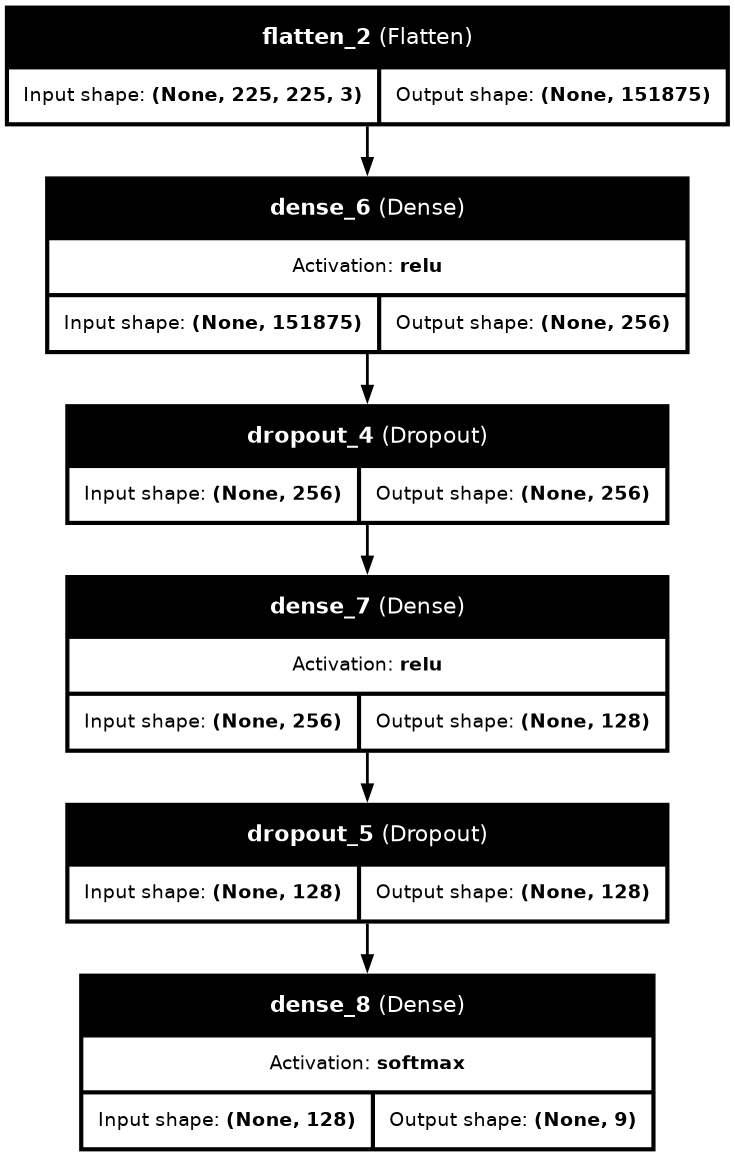

In [148]:
# Visualize our defined model using keras.utils.plot_model
keras.utils.plot_model(
    model,                        # An instance of a Keras model
    to_file="model.png",          # "name.format" to specify the saved file name
    show_shapes=True,            # Option to display shape information
    show_dtype=False,             # Option to display layer data types
    show_layer_names=True,       # Option to display names of layers
    rankdir="TB",                 # A parameter for the PyDot library
    expand_nested=False,          # Option to expand nested Functional models into clusters
    dpi=100,                      # Resolution of the image in dots per inch
    show_layer_activations=True, # Option to show layer activations
    show_trainable=False)         # Option to indicate if a layer is trainable 

In [149]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True)

Early stopping: A technique that prevents over-learning by stopping the training process as soon as the test error starts to increase.

## Model Training

In [150]:

num_epochs = 100
# Start the timer
start_time = time.time()

# Model fit
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=num_epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Stop the timer
end_time = time.time()

# Calculate and print the total training time
training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.2316 - loss: 2.9450 - val_accuracy: 0.4756 - val_loss: 1.5527
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4552 - loss: 1.5530 - val_accuracy: 0.6122 - val_loss: 1.1696
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5245 - loss: 1.3545 - val_accuracy: 0.6444 - val_loss: 1.0999
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5722 - loss: 1.2122 - val_accuracy: 0.6978 - val_loss: 0.9128
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6189 - loss: 1.0892 - val_accuracy: 0.6711 - val_loss: 1.0317
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6569 - loss: 0.9970 - val_accuracy: 0.7578 - val_loss: 0.7733
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6689 - loss: 0.9362 - val_accuracy: 0.7867 - val_loss: 0.6882
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6929 - loss: 0.8613 - 

In [151]:
#Validation set accuracy score
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 80.02%


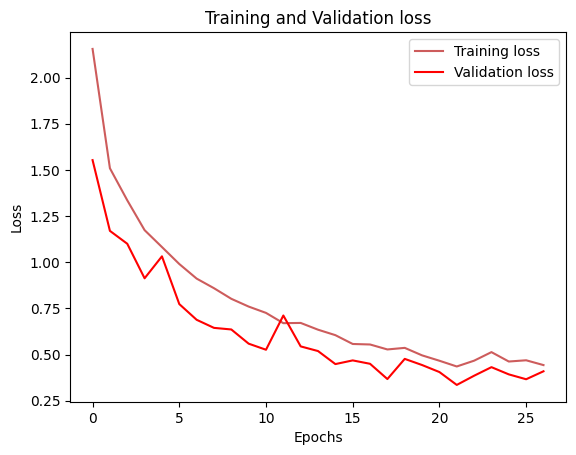

In [152]:
# Training and Validation loss graph
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

## **Model Evaluation**

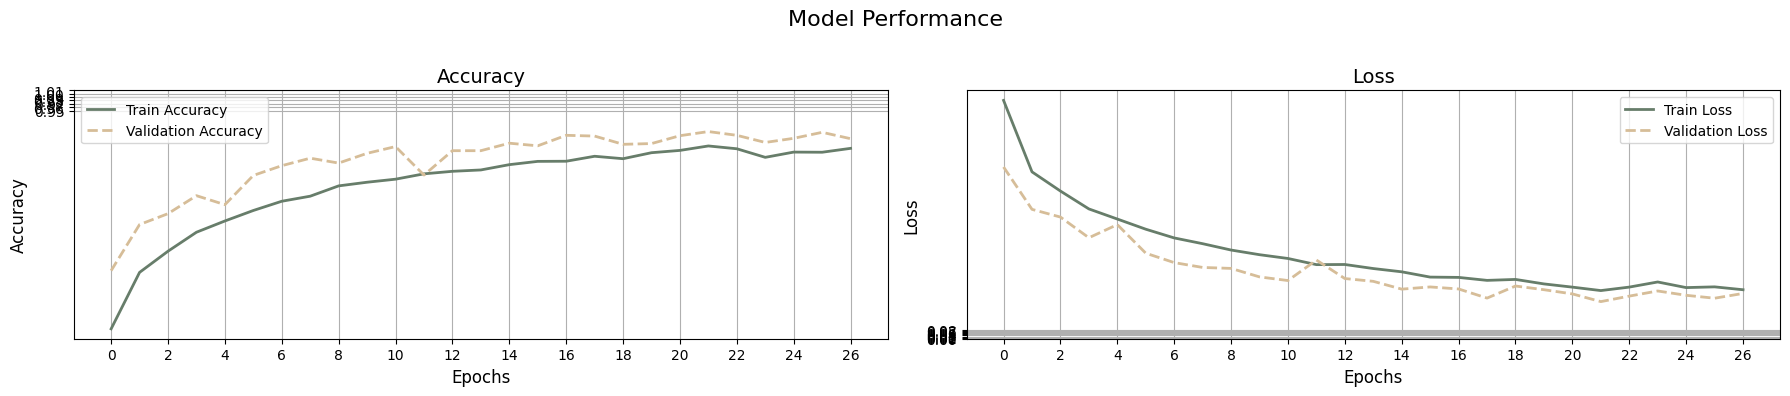

In [153]:
# Define a X variable to store range of epochs
x = np.arange(len(history_df))

# Initialize figure and axes for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
fig.suptitle('Model Performance', fontsize=16)

# ax[0] ---> Accuracy
ax[0].plot(x, history_df.accuracy, label='Train Accuracy', linewidth=2, color='#677D6A')
ax[0].plot(x, history_df.val_accuracy, label='Validation Accuracy', linewidth=2, linestyle='--', color='#D6BD98')
ax[0].set_title('Accuracy', fontsize=14)
ax[0].set_yticks(np.arange(0.95, 1.01, 0.01))
ax[0].set_xticks(np.arange(0, len(history_df), 2))
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend()
ax[0].grid(True)

# ax[1] ---> Loss
ax[1].plot(x, history_df.loss, label='Train Loss', linewidth=2, color='#677D6A')
ax[1].plot(x, history_df.val_loss, label='Validation Loss', linewidth=2, linestyle='--', color='#D6BD98')
ax[1].set_title('Loss', fontsize=14)
ax[1].set_xticks(np.arange(0, len(history_df), 2))
ax[1].set_yticks(np.arange(0, 0.085, 0.01))
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend()
ax[1].grid(True)

# Adjust layout to make room for the super title
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [154]:
#Test set accuracy value
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

29/29 - 0s - 9ms/step - accuracy: 0.9078 - loss: 0.3022
Test accuracy: 0.9077777862548828


              precision    recall  f1-score   support

           0       0.88      0.91      0.89        87
           1       0.94      0.93      0.93       100
           2       0.95      0.93      0.94       106
           3       0.93      1.00      0.97        85
           4       0.90      0.98      0.94        99
           5       0.89      0.89      0.89        97
           6       0.93      0.97      0.95       106
           7       0.97      0.84      0.90       116
           8       0.94      0.89      0.92       104

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



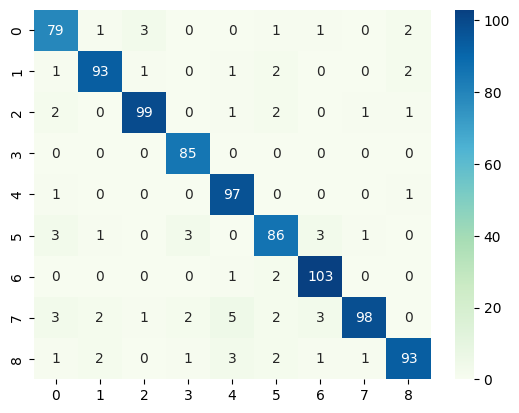

In [155]:
# Let's see the precision recall f1-score values
print(classification_report(y_true_labels, y_pred_labels))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='g', cmap="GnBu", cbar=True)
plt.show()

## Prediction from the model

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


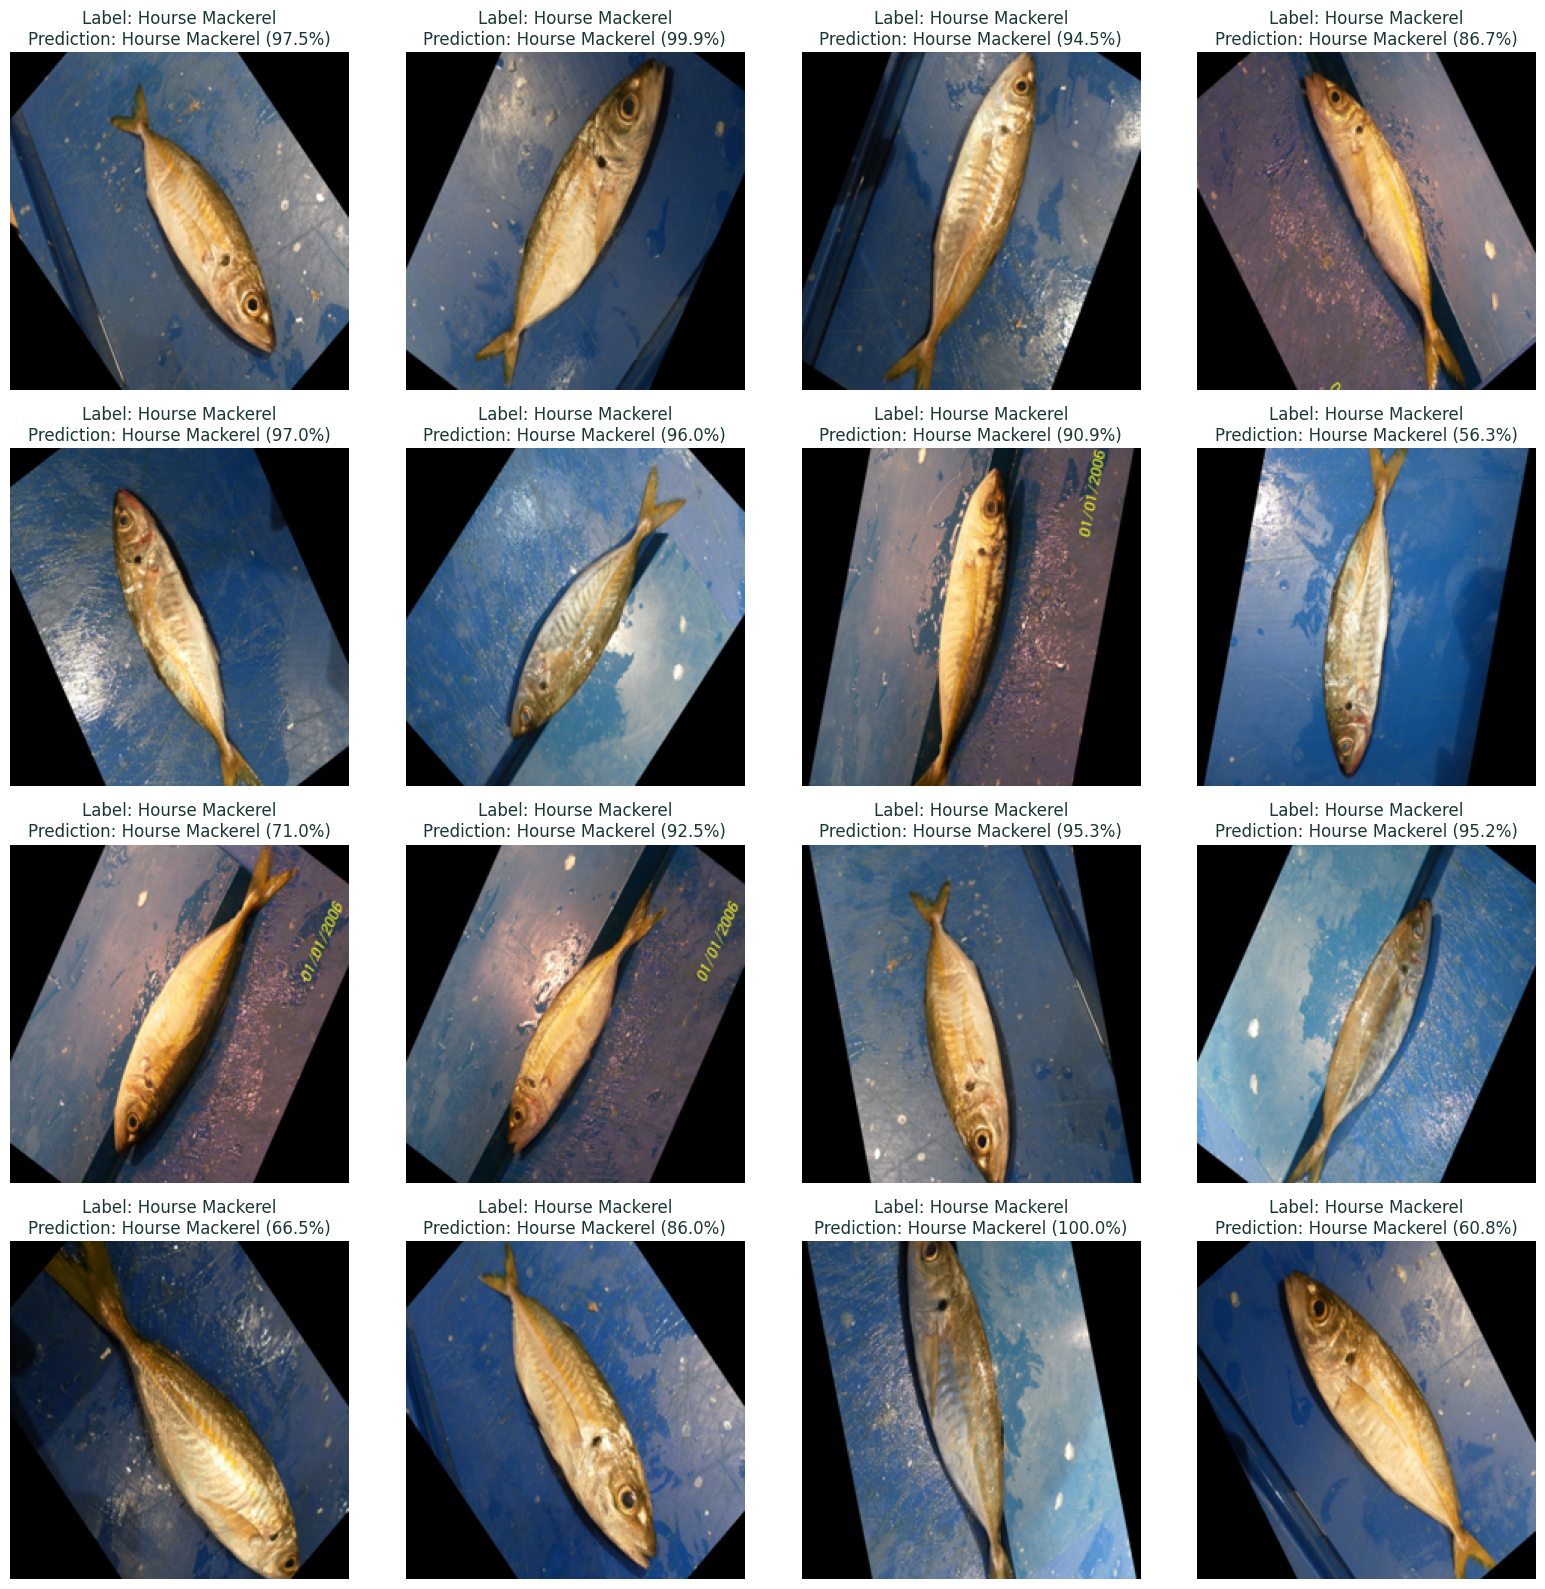

In [156]:
y_pred = model.predict(X_test)

# Extract the predicted classes from the model's output.
test_pred_classes = np.argmax(y_pred, axis=1)

# Set up the plot with a larger figure size for better clarity.
plt.figure(figsize=[16, 16])

# Loop through the first 16 images in the batch to display them along with their labels and predictions.
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.axis('off')  # Hide the axes for a cleaner look

    # Title with the true label, predicted class, and prediction confidence percentage
    plt.title(f"Label: {labels[np.argmax(label[i])]}\n"
              f"Prediction: {labels[test_pred_classes[i]]} "
              f"({100 * np.max(y_pred[i]):.1f}%)",
              fontsize=12, color='#1A3636')

# Adjust the layout to prevent overlapping of elements
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


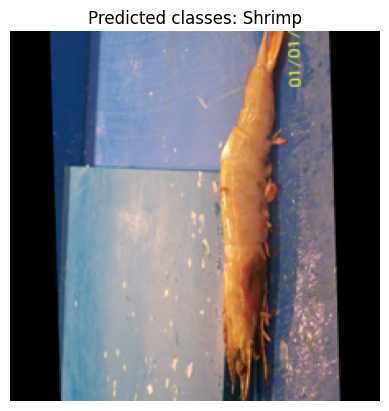

In [157]:
# Uploading a sample image
image_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00001.png'

# Open image with PIL, resize and normalize(convert to Numpy array)
test_img = Image.open(image_path) 
test_img = test_img.resize((225, 225)) 
test_img_array = np.array(test_img).astype('float32') / 255  

# Expand dimensions to create input in the format expected by the model(RGB-3)
test_img_array = np.expand_dims(test_img_array, axis=0)  # (225, 225, 3) 

# Making predictions from the model
predictions = model.predict(test_img_array)

# Assigning the resulting output to the predicted class index
predicted_class_index = np.argmax(predictions)

# Edit the sequence in One hot encoding format
one_hot_predicted_class = np.zeros((1, encoder.categories_[0].size))
one_hot_predicted_class[0][predicted_class_index] = 1

# Reverse convert class in one-hot format
predicted_class = encoder.inverse_transform(one_hot_predicted_class)

# Visualize the output
plt.imshow(test_img)  
plt.title(f'Predicted classes: {predicted_class[0][0]}')
plt.axis('Off') 
plt.show()